In [605]:
from Bio.PDB import *

import Bio.PDB as bpdb
from Bio.PDB.PDBIO import PDBIO
from Bio.PDB.DSSP import DSSP
from Bio.PDB.DSSP import dssp_dict_from_pdb_file
from Bio import SeqIO
from Bio import SearchIO
from Bio.SeqUtils import seq1
from Bio.SeqRecord import SeqRecord
from Bio.Seq import Seq

from Bio.PDB.Chain import Chain
from Bio.PDB.Atom import Atom
from Bio.PDB.Residue import Residue
from Bio.PDB.Model import Model

import pickle
import os
from os import path
from os.path import isfile, join, dirname, isdir, exists

import gudhi as gd
from scipy.optimize import minimize_scalar, least_squares

from IPython.display import Image
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.collections import LineCollection
import numpy.linalg as linalg
from scipy import sparse
import scipy.signal
from scipy.optimize import minimize
from scipy.ndimage import gaussian_filter1d, gaussian_filter

import sys
import math
from daps import *

from scipy.optimize import curve_fit


def get_curv_vectors(X, MaxOrder, sigma, loop = False, m = 'nearest'):

    from scipy.ndimage import gaussian_filter1d as gf1d
    if loop:
        m = 'wrap'
    XSmooth = gf1d(X, sigma, axis=0, order = 0, mode = m)
    Vel = gf1d(X, sigma, axis=0, order = 1, mode = m)
    VelNorm = np.sqrt(np.sum(Vel**2, 1))
    VelNorm[VelNorm == 0] = 1
    Curvs = [XSmooth, Vel]
    for order in range(2, MaxOrder+1):
        Tors = gf1d(X, sigma, axis=0, order=order, mode = m)
        for j in range(1, order):
            #Project away other components
            NormsDenom = np.sum(Curvs[j]**2, 1)
            NormsDenom[NormsDenom == 0] = 1
            Norms = np.sum(Tors*Curvs[j], 1)/NormsDenom
            Tors = Tors - Curvs[j]*Norms[:, None]
        Tors = Tors/(VelNorm[:, None]**order)
        Curvs.append(Tors)
    return Curvs

def sliding_window(dist, win):
    N = D.shape[0]
    dist_stack = np.zeros((N-win+1, N-win+1))
    for i in range(0, win):
        dist_stack += dist[i:i+N-win+1, i:i+N-win+1]
    for i in range(N-win+1):
        dist_stack[i, i] = 0
    return dist_stack

def get_csm(X, Y):
    if len(X.shape) == 1:
        X = X[:, None]
    if len(Y.shape) == 1:
        Y = Y[:, None]
    C = np.sum(X**2, 1)[:, None] + np.sum(Y**2, 1)[None, :] - 2*X.dot(Y.T)
    C[C < 0] = 0
    return np.sqrt(C)


def csm_to_binary(D, kappa):
    N = D.shape[0]
    M = D.shape[1]
    if kappa == 0:
        return np.ones_like(D)
    elif kappa < 1:
        NNeighbs = int(np.round(kappa*M))
    else:
        NNeighbs = kappa
    J = np.argpartition(D, NNeighbs, 1)[:, 0:NNeighbs]
    I = np.tile(np.arange(N)[:, None], (1, NNeighbs))
    V = np.ones(I.size)
    [I, J] = [I.flatten(), J.flatten()]
    ret = sparse.coo_matrix((V, (I, J)), shape=(N, M), dtype=np.uint8)
    return ret.toarray()

def csm_to_binary_mutual(D, kappa):
    return csm_to_binary(D, kappa)*(csm_to_binary(D.T, kappa).T)

def getUnweightedLaplacianEigsDense(W):
    D = sparse.dia_matrix((W.sum(1).flatten(), 0), W.shape).toarray()
    L = D - W
    try:
        _, v = linalg.eigh(L)
    except:
        return np.zeros_like(W)
    return v

def make_dir(*argv):
    mydir = path.join(*argv)    
    if not path.exists(mydir):        
        if len(argv) > 1:
            make_dir(*argv[:-1])            
        os.mkdir(mydir)
    return mydir


def make_path(*argv):
    mypath = path.join(*argv)
    if not path.exists(dirname(mypath)):
        make_dir(*argv[:-1])
    return mypath

def get_fasta_record(file, seqid):
    with open(file) as handle:
        for record in SeqIO.parse(handle, "fasta"):
            if record.id == seqid:
                return record
        raise Exception('did not find sequence')
    
def avgper(motifs):    
    diff = [second - first for first, second in zip(motifs, motifs[1:]) if second - first > 15]
    return int(np.mean(diff))

def get_LRR_curve(tairid):
    parser = PDBParser()
    structure = parser.get_structure(tairid, 'pdb/nlrome_LRR-hmm/%s.pdb'%tairid)
    chain = list(structure.get_chains())[0]
    return(np.array([np.array(list(residue["CA"].get_vector())) for residue in chain.get_residues()]))


def get_conf(tairid):
    parser = PDBParser()
    structure = parser.get_structure(tairid, 'pdb/nlrome_LRR-hmm/%s.pdb'%tairid)
    chain = list(structure.get_chains())[0]
    return [residue['CA'].get_bfactor() for residue in chain.get_residues()]

def estimate_coil_hmm(v1, v2, pcc=0.99, phh=0.99, muh=0, muc=0.7, sigma=0.3):

    ## Step 1: compute radius and max-normalize to [0, 1]

    r = np.sqrt(v1**2 + v2**2)
    r = r/np.max(r)
    
    ## Step 2: Setup transition probabilities for HMM
    # States: 0 - In hairpin
    #         1 - Not in hairpin
    ptrans = [[phh, 1-phh],
             [1-pcc, pcc]]
    ptrans = np.log(np.array(ptrans))


    ## Step 3: Viterbi algorithm
    r = np.concatenate(([0], r))
    N = len(r)
    P = np.zeros((2, N)) # Accumulated log probability matrix
    T = np.zeros((2, N), dtype=int) # Transition matrix

    for j in range(1, N):
        # Hairpin observation probability
        o1 = -(r[j]-muh)**2/(2*sigma**2)
        # Coil observation probability
        o2 = -(r[j]-muc)**2/(2*sigma**2)
        obs = [o1, o2]
        for i in range(2):
            ps = [0, 0]
            for k in range(2):
                ps[k] = P[k, j-1] + ptrans[k, i] + obs[i]
            T[i, j] = np.argmax(ps)
            P[i, j] = ps[T[i, j]]

    ## Backtracing
    i = 1
    states = [i]
    j = N-1
    while j > 0:
        i = T[i, j]
        states.append(i)
        j -= 1
    states.reverse()
    states = states[1::]
    return states


def get_hairpins(coil_est):
    hairpins = []
    N = len(coil_est)
    i1 = 0
    in_hairpin = coil_est[0] == 0
    for i in range(1, N):
        if in_hairpin and coil_est[i] == 1:
            hairpins.append([i1, i])
            in_hairpin = False
        elif not in_hairpin and coil_est[i] == 0:
            i1 = i
            in_hairpin = True
    return hairpins




def autocorr(x):
    """
    Fast autocorrelation based on the Wiener-Khinchin Theorem, which allows us
    to use the fast fourier transform of the input to compute the autocorrelation
    Parameters
    ----------
    x: ndarray(N)
        Array on which to compute the autocorrelation
    
    Returns
    -------
    ndarray(N): The autocorrelation
    """
    N = len(x)
    xpad = np.zeros(N*2)
    xpad[0:N] = x
    F = np.fft.fft(xpad)
    FConv = np.real(F)**2 + np.imag(F)**2 # Fourier transform of the convolution of x and its reverse
    return np.real(np.fft.ifft(FConv)[0:N])

def demodulate(v1, v2, bias=0.1, order=11):
    """
    Estimate a signal's envelope by finding the fundamental frequency,
    moving it to baseband, lowpass filtering it, and then using that
    as the envelope.
    Divide the original signal by this envelope plus a bias to avoid
    dividing by 0
    
    Parameters
    ----------
    v1: ndarray(N)
        First eigenvector
    v2: ndarray(N)
        Second eigenvector
    bias: float
        Add this to the envelope before dividing (this is a bit of a hack, but 
        it seems to work)
    order: int
        Order of FIR lowpass filter
    """
    from scipy import signal
    # Estimate period
    a = autocorr(v1)
    T = 10+np.argmax(a[10::])
    
    # Bring modulation back to "baseband" and filter out
    # with a lowpass filter
    demod = np.cos(2*np.pi*np.arange(v1.size)/T)
    cutoff = T/v1.size
    bands = (0, cutoff, cutoff, 0.5)
    desired = (1, 1, 0, 0)
    b = signal.firls(order, bands, desired, nyq=0.5)
    a = [1]
    w, h = signal.freqz(b)
    mod1 = signal.filtfilt(b, a, v1*demod)
    mod2 = signal.filtfilt(b, a, v2*demod)
    
    # Divide by the estimated modulation
    r = np.sqrt(mod1**2+mod2**2)
    r = bias + r/np.max(r) # This "bias" is a bit of a hack, but it seems to work
    v1filt = v1/r
    v2filt = v2/r
    return v1filt, v2filt

def compromise(a,b):
    # normalize
    a /= np.linalg.norm(a)
    b /= np.linalg.norm(b)

    # ensure a, b orthogonal
    mid = a + b
    mid *= np.sqrt(2) / (2 * np.linalg.norm(mid))
    diff = b - a
    diff *= np.sqrt(2) / (2 * np.linalg.norm(diff))

    a = mid - diff
    b = mid + diff

    # normalize
    a /= np.linalg.norm(a)
    b /= np.linalg.norm(b)
    return a,b


def linear_func(x, m, b):
    return m * x + b

In [606]:
with open('pickles/uniprot_d.pickle', 'rb') as handle:
    uniprot_d = pickle.load(handle)
with open('pickles/nlrome_matches_d.pickle', 'rb') as handle:
    matches_d = pickle.load(handle)
with open('pickles/nlrome_motifs_d.pickle', 'rb') as handle:
    motifs_d = pickle.load(handle)
with open('pickles/nlrome_matches_d.pickle', 'rb') as handle:
    matches_d = pickle.load(handle)    
with open('pickles/LRR_hmm_d.pickle', 'rb') as handle:
    LRR_hmm_d = pickle.load(handle)   
with open('pickles/cutoff_d.pickle', 'rb') as handle:
    cutoff_d = pickle.load(handle)   
    
with open('pickles/nlrome_mismatches_d.pickle', 'rb') as handle:
    mismatches_d = pickle.load(handle)
with open('pickles/totpers_d.pickle', 'rb') as handle:
    totpers_d = pickle.load(handle)
with open('pickles/motifs_shifted_d.pickle', 'rb') as handle:
    motifs_shifted_d = pickle.load(handle)

with open('pickles/unique_matches_d.pickle', 'rb') as handle:
    unique_matches_d = pickle.load(handle)  

In [607]:
if False:
    LRR_hmm_d = {}

    ethresh = 1e-5 ### adjust this for e-value threshold

    hmmmsearch_domout_path = make_path('hmmsearch_dom', 'athaliana.txt')

    qresult = next(SearchIO.parse(hmmmsearch_domout_path, 'hmmsearch3-domtab'))
    filtered_hits = list(filter(lambda hsp: hsp.evalue < ethresh, qresult.hsps))
    hit_ids = [hsp.hit_id for hsp in filtered_hits]
    with open(make_path('protein', 'col-hmm-LRR.fa'), "w") as output_handle:
        for tairid, uniid in uniprot_d.items():
            #     hit_sequences = sorted([record for record in prot_l if record.id in hit_ids], key=lambda a: hit_ids.index(a.id))
            #     print('\n'.join([f'E-value: {filtered_hits[ii].evalue} for ' + hit_sequences[ii].description for ii in range(numTop)]))

            found = False
            ends_l = []
            evalue_l = []
            for hsp in filtered_hits:                
                if hsp.hit_id == "ATHALIANA_%s"%tairid.replace('.','_'):
                    ends_l.append(hsp.env_end)
                    evalue_l.append(-np.log(hsp.evalue))
                    found = True
            if found:
                if len(ends_l)>1:          
                    hitrank = sorted(zip(ends_l,evalue_l), key=lambda tup: tup[1], reverse = True)
                    hitrank_filt = [tup for tup in hitrank if hitrank[0][1] - tup[1]<3]
                    cutoff = min(hitrank_filt, key=lambda tup: tup[1])[0]
                    if len(hitrank_filt)>1:
                        print('multiple nb-arc hits', tairid, hitrank_filt, cutoff)          
                elif len(ends_l) == 1:
                    cutoff = ends_l[0]
                    hitrank_filt = zip(ends_l, evalue_l)
                else:
                    raise Exception('no nbarc found')
                record = get_fasta_record(make_path('protein', 'corr.Athaliana.protein.fasta'), "ATHALIANA_%s"%tairid.replace('.','_'))
                record = record[cutoff:]
                record.id += '|%d'%cutoff
                record.description = '|'.join(["%d_%d"%(tup[0],int(tup[1])) for tup in hitrank_filt])
                SeqIO.write(record, output_handle, "fasta")
                LRR_hmm_d[tairid] = cutoff
            else:
                print('record ', record.id, 'nb-arc domain not found')

            if True:
                parser = PDBParser()
                structure = parser.get_structure(uniid, 'afdb/%s.pdb'%uniid)

                chain = list(structure.get_chains())[0]

                class ResSelect(bpdb.Select):
                    def accept_residue(self, res):
                        if res.id[1] >= cutoff:
                            return True
                        else:
                            return False            
                io = bpdb.PDBIO()       
                io.set_structure(chain)
                io.save(make_path('pdb', 'nlrome_LRR-hmm','%s.pdb'%tairid), ResSelect())                

    with open('pickles/LRR_hmm_d.pickle', 'wb') as handle:
        pickle.dump(LRR_hmm_d, handle)    

In [608]:
if False:
    for tairid, uniid in uniprot_d.items():
        parser = PDBParser()
        structure = parser.get_structure(uniid, 'afdb/%s.pdb'%uniid)

        chain = list(structure.get_chains())[0]

        cutoff = LRR_hmm_d[tairid]
        class ResSelect(bpdb.Select):
            def accept_residue(self, res):
                if res.id[1] >= 0:
                    return True
                else:
                    return False                        

        for residue in list(chain.get_residues()):
            residue._id = (' ', residue.id[1]-cutoff, ' ')
        io = bpdb.PDBIO()       
        io.set_structure(chain)
        io.save(make_path('pdb', 'nlrome_LRR-hmm','%s.pdb'%tairid), ResSelect())                


In [609]:
if False:
# prot_l = []
# id_l = []

# for record in SeqIO.parse(make_path('protein', 'corr.Athaliana.protein.fasta'), "fasta"):
#     prot_l.append(record)
#     id_l.append(record.id)        


# LRR_l = []
# ethresh = 1e-7 ### adjust this for e-value threshold

# hmmmsearch_domout_path = make_path('hmmsearch_dom', 'athaliana.txt')

# qresult = next(SearchIO.parse(hmmmsearch_domout_path, 'hmmsearch3-domtab'))
# filtered_hits = list(filter(lambda hsp: hsp.evalue < ethresh, qresult.hsps))
# hit_ids = [hsp.hit_id for hsp in filtered_hits]
# #     hit_sequences = sorted([record for record in prot_l if record.id in hit_ids], key=lambda a: hit_ids.index(a.id))
# #     print('\n'.join([f'E-value: {filtered_hits[ii].evalue} for ' + hit_sequences[ii].description for ii in range(numTop)]))
# with open(make_path('protein', 'col-hmm-LRR.fa'), "w") as output_handle:
#     for record in prot_l:
#         found = False
#         ends_l = []
#         evalue_l = []
#         for hsp in filtered_hits:                
#             if hsp.hit_id == record.id:
#                 ends_l.append(hsp.env_end)
#                 evalue_l.append(-np.log(hsp.evalue))
#                 found = True
#         if found:
#             if len(ends_l)>1:
#                 print('multiple nb-arc hits', ends_l, record.id)                    
#                 hitrank = sorted(zip(ends_l,evalue_l), key=lambda tup: tup[1], reverse = True)
#                 hitrank_filt = [tup for tup in hitrank if hitrank[0][1] - tup[1]<3]
#                 cutoff = min(hitrank_filt, key=lambda tup: tup[0])[0]
#                 print('filtered', hitrank_filt, cutoff)
#             elif len(ends_l) == 1:
#                 cutoff = ends_l[0]
#             else:
#                 raise Exception('no nbarc found')
#             record = record[cutoff:]
#             record.id += '|%d'%cutoff
#             record.description = '|'.join([str(_) for _ in ends_l])
#             SeqIO.write(record, output_handle, "fasta")
#             LRR_l.append(record)
#         else:
#             print('record ', record.id, 'nb-arc domain not found')

IndentationError: expected an indented block (545569286.py, line 47)

In [ ]:
if False:

    tairid = 'AT3G44480.1'
    for record in LRR_l:
        if '.'.join(record.id.split('|')[0].split('_')[1:]) == tairid:
            LRRStart = int(record.description)
            break

In [ ]:
if False:
# import Bio.PDB as bpdb

# for tairid, uniid in uniprot_d.items():

#     parser = PDBParser()
#     structure = parser.get_structure(uniid, 'afdb/%s.pdb'%uniid)

#     chain = list(structure.get_chains())[0]

#     io = bpdb.PDBIO()        

#     io.set_structure(chain)
#     io.save(make_path('pdb', 'nlrome_whole','%s.pdb'%tairid))

In [ ]:
# for tairid, uniid in uniprot_d.items():    
#     for record in LRR_l:
#         if '.'.join(record.id.split('|')[0].split('_')[1:]) == tairid:
#             start_res = int(record.description.split('|')[0])
#             break    
#     parser = PDBParser()
#     structure = parser.get_structure(uniid, 'afdb/%s.pdb'%uniid)

#     chain = list(structure.get_chains())[0]

#     class ResSelect(bpdb.Select):
#         def accept_residue(self, res):
#             if res.id[1] >= start_res:
#                 return True
#             else:
#                 return False
            
#     io = bpdb.PDBIO()       

#     io.set_structure(chain)
#     io.save(make_path('pdb', 'nlrome_LRR-hmm','%s.pdb'%tairid), ResSelect())

In [ ]:
# for (tairid, uniid), motifs in motifs_d.items():
#     start_res, end_res=motifs[0],motifs[-1]

#     parser = PDBParser()
#     structure = parser.get_structure(uniid, 'afdb/%s.pdb'%uniid)

#     chain = list(structure.get_chains())[0]

#     class ResSelect(bpdb.Select):
#         def accept_residue(self, res):
#             if res.id[1] >= start_res and res.id[1] <= end_res:
#                 return True
#             else:
#                 return False
            
#     io = bpdb.PDBIO()        

#     io.set_structure(chain)
#     io.save(make_path('pdb', 'nlrome_LRR','%s.pdb'%uniid), ResSelect())

In [ ]:
if False:
    for tairid in uniprot_d.keys():
        parser = PDBParser()
        structure = parser.get_structure(tairid, 'pdb/nlrome_LRR-hmm/%s.pdb'%tairid)
        chain = list(structure.get_chains())[0]

        alpha_carbons=[]

        for ii, residue in enumerate(chain.get_residues()):    
            if residue.get_full_id()[3][1] >= LRR_hmm_d[tairid]:
                alpha_carbons.append(np.array(list(residue["CA"].get_vector())))
            else:
                raise Exception()

        X = np.array(alpha_carbons)
        X.shape

        windowSize = 25

        totpers_l=[]
        for windowStart in range(X.shape[0]- windowSize-1):
            Y = X[windowStart:windowStart+windowSize,:]
            stree = gd.AlphaComplex(points = Y).create_simplex_tree()
            dgm = stree.persistence()
            dgm1_lens = [d-b for (dim, (b, d)) in dgm if dim == 1]
            dgmstat = sum(dgm1_lens)
            # gd.plot_persistence_diagram(dgm, legend = True)
            totpers_l.append(dgmstat)
        np.save(make_path('npy', 'totpers', '%s.npy'%tairid), np.array(totpers_l))

            # break            

In [ ]:
#compute swtp
if False:
    from matplotlib.collections import LineCollection

    cutoff_d = {}

    for tairid, swtp in totpers_d.items():
        # g = gaussian_filter1d(swtp, 15)
        # if tairid !=  'AT5G44510.1':
        #     continue
        g = swtp

        # g = g-np.min(g)
        # g = g/np.quantile(g, .95)

        N= g.shape[0]

        mins = []
        argmins = []
        conf = np.array(get_conf(tairid)[:N])

        A = np.array([np.sum((g[:t] - np.sum(g[:t]) / np.max([1, t])) ** 2) + 0.5 * np.sum(g[t:] ** 2) for t in range(len(g))])
        t = np.argmin(A)

        cutoff_d[tairid] = t

        if False:
            myrect = (np.sum(g[:t]) / np.max([1, t])) * np.array([int(i < t) for i in range(len(g))])



            # for h in range(int(np.max(g))):
            #     def f(x):
            #         return np.sum(np.array([(g[ii] - h) if ii < x else g[ii]/2 for ii in range(N)])**2)
            #     res = minimize_scalar(f, bounds = (0, N), method='bounded')
            #     mins.append(res.fun)
            #     argmins.append(int(res.x))

            # h = np.argmin(mins)
            # b = argmins[h]
            # print(h,b)

            x = np.arange(N)
            y = g
            points = np.array([x, y]).T.reshape(-1, 1, 2)
            segments = np.concatenate([points[:-1], points[1:]], axis=1)
            
            
            fig, axs = plt.subplots(1, 1, sharex=True, sharey=True)
            norm = plt.Normalize(conf.min(), conf.max())
            lc = LineCollection(segments, cmap='viridis', norm=norm)
            # Set the values used for colormapping
            lc.set_array(conf)
            lc.set_linewidth(2)
            line = axs.add_collection(lc)
            fig.colorbar(line, ax=axs)    

            # plt.plot(g)
            plt.plot(myrect)
            # plt.axhline(h, color = 'r')
            # plt.axvline(b, color = 'r')

            plt.savefig(make_path('plots','swtp_myrect', '%s.png'%tairid))
            plt.close()


In [ ]:
#make motif dictionary
if False:
    motifs_shifted_d = {}
    for k, v in motifs_d.items():
        LRRstart = LRR_hmm_d[k]
        motifs_shifted_d[k] = [num-LRRstart for num in v]

    with open('pickles/motifs_shifted_d.pickle', 'wb') as handle:
        pickle.dump(motifs_shifted_d, handle)        

In [638]:
# #multiple breakpoint regression. didn't work

# def linear_func(x, m, b):
#     return m * x + b
# for tairid, uniid in unique_matches_d.items():

        
#     if tairid != 'AT1G17600.1':
#         continue

#     preX = get_LRR_curve(tairid)
    

#     X = scipy.ndimage.gaussian_filter(preX, [1, 0])
#     Y = scipy.ndimage.gaussian_filter(X, [20, 0])
#     dY = scipy.ndimage.gaussian_filter(Y, [1,0], order = 1)
#     dZ = dY / np.sqrt(np.sum(dY ** 2, axis = 1))[:, np.newaxis]

#     # need orthonormal pair of vectors for each point on curve that are orthogonal to tangent vector
#     V = np.zeros((len(dZ), 2, 3))
#     V[0,0] = np.random.rand(3)
#     V[0,1] = np.random.rand(3)

#     for i, z in enumerate(dZ):
#         # project onto current tangent vector
#         if i:
#             V[i] = V[i-1]

#         V[i,0] -= (V[i,0] @ z) * z
#         V[i,1] -= (V[i,1] @ z) * z
        
#         V[i,0], V[i,1] = compromise(V[i,0], V[i,1])    
        
#     Q = np.zeros((len(dZ), 2))
#     for i in range(len(Q)):
#         Q[i] = [(X[i] - Y[i]) @ V[i,0], (X[i] - Y[i]) @ V[i,1]]
        
#     # plt.plot(Q)
#     # plt.show()
#     # plt.plot(*Q.T)
#     # plt.show()

#     s = Q[:,0]
#     c = Q[:,1]
#     ds = gaussian_filter(s, 0.5, order = 1)
#     dc = gaussian_filter(c, 0.5, order = 1)

#     r2 = s ** 2 + c ** 2

#     summand = (c * ds - s * dc) / r2

#     g =np.cumsum(summand)
#     N = len(g)

#     A_l = []
#     param_l = []

#     maxBp = 2
#     from itertools import combinations
#     from collections import defaultdict
#     for numBp in range(1, maxBp+1):
#         A = []
#         param_d = defaultdict(lambda : [])
#         if numBp ==1:
#             breakpts = [ti for ti in range(2,N-2)]
#         else:
#             breakpts = [ti for ti in combinations(range(2,N-2), numBp) if np.min(np.diff(list(ti)))>5]
#         for ti in breakpts:
#             if type(ti) is int:                
#                 ti0 = [0]+[ti]+[N]
#             else:
#                 ti0 = [0]+list(ti)+[N]
#             loss = 0
#             for inf, sup in zip(ti0[:-1], ti0[1:]):
#                 (m_opt, b_opt), covariance = curve_fit(linear_func, range(inf, sup), g[inf:sup])            
#                 coilRes = (g[inf:sup] - [linear_func(x, m_opt, b_opt) for x in range(inf, sup)])
#                 loss += np.sum(coilRes**2)
#             A.append(loss)
#             param_d[ti].append((m_opt, b_opt))
#         minidx = np.argmin(A)
#         minti = breakpts[minidx]
#         min_param = param_d[minti]
#         param_l.append(min_param)
#         A_l.append(A[minidx])
#     print(A_l)

#     break
#     plt.plot(g)
#     plt.plot([linear_func(x, m_opt, b_opt) for x in range(t)], c = 'r')
#     plt.hlines(y=np.sum(g[t:]) / np.max([1, N-t]), xmin=t, xmax = N, color = 'r', linestyle='-')
#     plt.axvline(x = t, color = 'g')
#     plt.show()
#     # plt.savefig(make_path('plots', 'theta_cutoff_nlrome', f'{tairid}.png'))    

#     plt.close()        

#     # A = np.array([np.sum((g[t:] - np.sum(g[t:]) / np.max([1, N-t])) ** 2) + np.sum((g[:t] - [g[t]*x/t for x in range(0,t)])**2) for t in range(N)])
#     # t = np.argmin(A)
#     # m = g[t]/t
#     # plt.plot(g)
#     # plt.plot([m*x for x in range(0, t)], c = 'r')
#     # plt.hlines(y=np.sum(g[t:]) / np.max([1, N-t]), xmin=t, xmax = N, color = 'r', linestyle='-')
#     # plt.axvline(x = t, color = 'g')
#     # plt.show()
#     # plt.close()


In [ ]:
# #multiple breakpoints didn't work

# for tairid, uniid in unique_matches_d.items():        
#     if tairid != 'AT1G17600.1':
#         continue
#     preX = get_LRR_curve(tairid)    
#     X = scipy.ndimage.gaussian_filter(preX, [1, 0])
#     Y = scipy.ndimage.gaussian_filter(X, [20, 0])
#     dY = scipy.ndimage.gaussian_filter(Y, [1,0], order = 1)
#     dZ = dY / np.sqrt(np.sum(dY ** 2, axis = 1))[:, np.newaxis]
#     # need orthonormal pair of vectors for each point on curve that are orthogonal to tangent vector
#     V = np.zeros((len(dZ), 2, 3))
#     V[0,0] = np.random.rand(3)
#     V[0,1] = np.random.rand(3)
#     for i, z in enumerate(dZ):
#         # project onto current tangent vector
#         if i:
#             V[i] = V[i-1]
#         V[i,0] -= (V[i,0] @ z) * z
#         V[i,1] -= (V[i,1] @ z) * z
#         V[i,0], V[i,1] = compromise(V[i,0], V[i,1])    
        
#     Q = np.zeros((len(dZ), 2))
#     for i in range(len(Q)):
#         Q[i] = [(X[i] - Y[i]) @ V[i,0], (X[i] - Y[i]) @ V[i,1]]

#     s = Q[:,0]
#     c = Q[:,1]
#     ds = gaussian_filter(s, 0.5, order = 1)
#     dc = gaussian_filter(c, 0.5, order = 1)

#     r2 = s ** 2 + c ** 2

#     summand = (c * ds - s * dc) / r2

#     g =np.cumsum(summand)
#     N = len(g)



#     A_l = []
#     param_l = []
#     ti_l = []
#     slopes_l =[]
#     maxBp = 2

    
#     from itertools import combinations
#     from collections import defaultdict
#     for numBp in range(1, maxBp+1):
#         A = []
#         print(numBp)
#         param_d = defaultdict(lambda : [])
#         if numBp ==1:
#             breakpts = [(ti,) for ti in range(2,N-2)]
#         else:
#             breakpts = [ti for ti in combinations(range(2,N-2), numBp) if np.min(np.diff(list(ti)))>5]
#         for ti in breakpts:
#             ti0 = [0]+list(ti)+[N]
#             loss = 0
#             coil = []
#             loss0 = 0
#             loss1 = 0
#             slopes0 = []
#             slopes1 = []
#             for kk, (inf, sup) in enumerate(zip(ti0[:-1], ti0[1:])):
#                 # n, bins, patches = plt.hist(summand, bins = 100)
#                 # plt.close()
#                 # m = bins[np.argmax(n)]
#                 (m_opt, b_opt), covariance = curve_fit(linear_func, range(inf, sup), g[inf:sup])            
#                 # coilRes = g[inf:sup] - [linear_func(x, m_opt, b_opt) for x in range(inf, sup)]
#                 m = m_opt        
#                 hm = g[inf:sup] - m*np.arange(inf,sup)
#                 # hm -= np.mean(hm)
#                 h = g[inf:sup]
#                 h -= np.mean(h)                
#                 if (kk+1)%2:                
#                     loss0 += np.sum(hm**2)
#                     loss1 += np.sum(h**2)
#                     slopes0.append(m)
#                     slopes1.append(0)
#                 else:
#                     loss0 += np.sum(h**2)
#                     loss1 += np.sum(hm**2)
#                     slopes0.append(0)
#                     slopes1.append(m)                    
#             if loss0 < loss1:
#                 loss = loss0
#                 param_d[ti] = slopes0
#             else:
#                 loss = loss1
#                 param_d[ti] = slopes1
#             A.append(loss)            
#         minidx = np.argmin(A)
#         minti = breakpts[minidx]
#         ti_l.append(minti)
#         param_l.append(param_d[minti])
#         A_l.append(A[minidx])
#     print(A_l)

#     bestBpNum = np.argmin(A_l)

#     slopes = param_l[bestBpNum]
#     ti = ti_l[bestBpNum]

#     ti0 = [0]+list(ti)+[N]

#     plt.plot(g)
#     for kk, (inf, sup) in enumerate(zip(ti0[:-1], ti0[1:])):
#         m = slopes[kk]
#         b = np.mean(g[inf:sup] - m*np.arange(inf,sup))
#         plt.plot([inf, sup], [m*inf+b, m*sup+b], 'r')
#     for t in ti:
#         plt.axvline(x = t, color = 'g')
#     plt.show()
#     # plt.savefig(make_path('plots', 'theta_breakpoint_nlrome', f'{tairid}.png'))    

#     plt.close()        

#     # A = np.array([np.sum((g[t:] - np.sum(g[t:]) / np.max([1, N-t])) ** 2) + np.sum((g[:t] - [g[t]*x/t for x in range(0,t)])**2) for t in range(N)])
#     # t = np.argmin(A)
#     # m = g[t]/t
#     # plt.plot(g)
#     # plt.plot([m*x for x in range(0, t)], c = 'r')
#     # plt.hlines(y=np.sum(g[t:]) / np.max([1, N-t]), xmin=t, xmax = N, color = 'r', linestyle='-')
#     # plt.axvline(x = t, color = 'g')
#     # plt.show()
#     # plt.close()


1


/Users/boyanxu/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


2


KeyboardInterrupt: 

In [640]:
# multiple breakpoints didn't work
# for tairid, uniid in unique_matches_d.items():        
#     # if tairid != 'AT1G17600.1':
#     #     continue

#     preX = get_LRR_curve(tairid)
    
#     X = scipy.ndimage.gaussian_filter(preX, [1, 0])
#     Y = scipy.ndimage.gaussian_filter(X, [20, 0])
#     dY = scipy.ndimage.gaussian_filter(Y, [1,0], order = 1)
#     dZ = dY / np.sqrt(np.sum(dY ** 2, axis = 1))[:, np.newaxis]
#     # need orthonormal pair of vectors for each point on curve that are orthogonal to tangent vector
#     V = np.zeros((len(dZ), 2, 3))
#     V[0,0] = np.random.rand(3)
#     V[0,1] = np.random.rand(3)
#     for i, z in enumerate(dZ):
#         # project onto current tangent vector
#         if i:
#             V[i] = V[i-1]
#         V[i,0] -= (V[i,0] @ z) * z
#         V[i,1] -= (V[i,1] @ z) * z
#         V[i,0], V[i,1] = compromise(V[i,0], V[i,1])    
        
#     Q = np.zeros((len(dZ), 2))
#     for i in range(len(Q)):
#         Q[i] = [(X[i] - Y[i]) @ V[i,0], (X[i] - Y[i]) @ V[i,1]]

#     s = Q[:,0]
#     c = Q[:,1]
#     ds = gaussian_filter(s, 0.5, order = 1)
#     dc = gaussian_filter(c, 0.5, order = 1)

#     r2 = s ** 2 + c ** 2

#     summand = (c * ds - s * dc) / r2

#     g =np.cumsum(summand)
#     N = len(g)

#     n, bins, patches = plt.hist(summand, bins = 100)
#     plt.close()
#     most_common_bin_index = np.argmax(n)
#     m = bins[most_common_bin_index]

#     A_l = []
#     param_l = []
#     ti_l = []

#     maxBp = 2
#     from itertools import combinations
#     from collections import defaultdict
#     for numBp in range(1, maxBp+1):
#         A = []
#         param_d = defaultdict(lambda : [])        
#         if numBp ==1:
#             breakpts = [(ti,) for ti in range(2,N-2)]
#         else:
#             breakpts = [ti for ti in combinations(range(2,N-2), numBp) if np.min(np.diff(list(ti)))>5]
#         for ti in breakpts:
#             ti0 = [0]+list(ti)+[N]
#             loss = 0
#             coil = []
#             loss0 = 0
#             for kk, (inf, sup) in enumerate(zip(ti0[:-1], ti0[1:])):
#                 hm = g[inf:sup] - (m*((kk+1)%2))*np.arange(inf,sup)
#                 hm -= np.mean(hm)
#                 loss0 += np.sum(hm**2)

#             loss1 = 0
#             for kk, (inf, sup) in enumerate(zip(ti0[:-1], ti0[1:])):
#                 hm = g[inf:sup] - (m*(kk%2))*np.arange(inf,sup)
#                 hm -= np.mean(hm)
#                 loss1 += np.sum(hm**2)         
#             if loss0 < loss1:
#                 loss = loss0
#                 param_d[ti] = 0
#             else:
#                 loss = loss1
#                 param_d[ti] = 1
#             A.append(loss)            
#         minidx = np.argmin(A)
#         minti = breakpts[minidx]
#         ti_l.append(minti)
#         param_l.append(param_d[minti])
#         A_l.append(A[minidx])
#     print(A_l)

#     bestBpNum = np.argmin(A_l)

#     param = param_l[bestBpNum]
#     ti = ti_l[bestBpNum]

#     ti0 = [0]+list(ti)+[N]

#     plt.plot(g)
#     for kk, (inf, sup) in enumerate(zip(ti0[:-1], ti0[1:])):
        
#         if not (kk+param)%2:
#             b = np.mean(g[inf:sup] - m*np.arange(inf,sup))
#             plt.plot([inf, sup], [m*inf+b, m*sup+b], 'r')
#         else:
#             plt.hlines(y= np.mean(g[inf:sup]), xmin=inf, xmax = sup, color = 'r', linestyle='-')
#     for t in ti:
#         plt.axvline(x = t, color = 'g')
#     # plt.show()
#     plt.savefig(make_path('plots', 'theta_breakpoint_nlrome', f'{tairid}.png'))    

#     plt.close()        

#     # A = np.array([np.sum((g[t:] - np.sum(g[t:]) / np.max([1, N-t])) ** 2) + np.sum((g[:t] - [g[t]*x/t for x in range(0,t)])**2) for t in range(N)])
#     # t = np.argmin(A)
#     # m = g[t]/t
#     # plt.plot(g)
#     # plt.plot([m*x for x in range(0, t)], c = 'r')
#     # plt.hlines(y=np.sum(g[t:]) / np.max([1, N-t]), xmin=t, xmax = N, color = 'r', linestyle='-')
#     # plt.axvline(x = t, color = 'g')
#     # plt.show()
#     # plt.close()


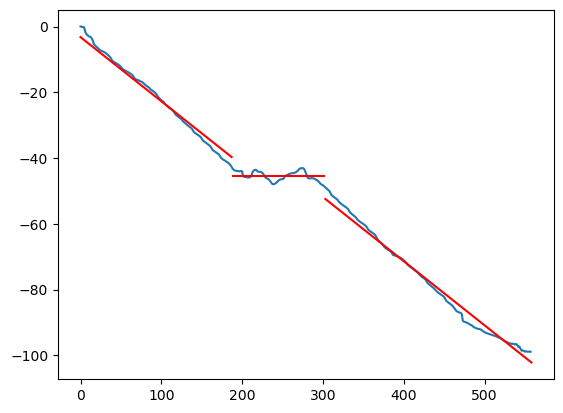

In [ ]:
#multiple breakpoints
# bestBpNum = np.argmin(A_l)

# param = param_l[bestBpNum]
# ti = ti_l[bestBpNum]

# ti0 = [0]+list(ti)+[N]

# plt.plot(g)
# for kk, (inf, sup) in enumerate(zip(ti0[:-1], ti0[1:])):
#     if not (kk+param)%2:
#         b = np.mean(g[inf:sup] - m*np.arange(inf,sup))
#         plt.plot([inf, sup], [m*inf+b, m*sup+b], 'r')
#     else:
#         plt.hlines(y= np.mean(g[inf:sup]), xmin=inf, xmax = sup, color = 'r', linestyle='-')
# plt.show()

In [618]:
#generates core pdb file for figure in paper

if False:
    io = bpdb.PDBIO()
    for tairid, uniid in unique_matches_d.items():
        parser = PDBParser()
        structure = parser.get_structure(uniid, make_path('pdb', 'nlrome_LRR-hmm','%s.pdb'%tairid))
        model = list(structure.get_models())[0]
        normalBundle = np.load(make_path('npy', 'normal_bundle_nlrome', f"{tairid}.npy"))
        Y, V0, V1 = tuple([normalBundle[ii, :, :] for ii in range(3)])
        for jj, dY in enumerate([np.zeros(Y.shape)]+[normalBundle[ii, :, :] for ii in range(1, 3)]):     
            core_chain = Chain('C')
            for ii in range(Y.shape[0]):
                res = Residue((' ', ii, ' '), 'LEU', '')
                res.add(Atom('C', Y[ii, :]+2*dY[ii,:], 100, 1.0, ' ', 'C', ii,element='C'))
                core_chain.add(res)
        # v0_chain = Chain('U')
        # for ii in range(Y.shape[0]):
        #     res = Residue((' ', ii, ' '), 'LEU', '')
        #     res.add(Atom('C', Y[ii, :]+V0[ii, :], 100, 1.0, ' ', 'C', ii,element='C'))
        #     v0_chain.add(res)        
        # model.add(v0_chain)

        # v1_chain = Chain('V')
        # for ii in range(Y.shape[0]):
        #     res = Residue((' ', ii, ' '), 'LEU', '')
        #     res.add(Atom('C', Y[ii, :]+V1[ii, :], 100, 1.0, ' ', 'C', ii,element='C'))
        #     v1_chain.add(res)        
        # model.add(v1_chain)

            io.set_structure(core_chain)
            io.save(make_path('pdb', 'nlrome_LRR-core',tairid, '%d.pdb'%jj))
        
        # io.save(make_path('pdb', 'nlrome_LRR-core','%s.pdb'%tairid))  


In [635]:
#best performing winding number calculation

postLRR_cutoff = {}

def linear_func(x, m, b):
    return m * x + b
for tairid, uniid in unique_matches_d.items():

        
    if tairid != 'AT1G64070.1':
        continue

    preX = get_LRR_curve(tairid)
    

    X = scipy.ndimage.gaussian_filter(preX, [1, 0])
    Y = scipy.ndimage.gaussian_filter(X, [20, 0])
    dY = scipy.ndimage.gaussian_filter(Y, [1,0], order = 1)
    dZ = dY / np.sqrt(np.sum(dY ** 2, axis = 1))[:, np.newaxis]

    def compromise(a,b):
        # normalize
        a /= np.linalg.norm(a)
        b /= np.linalg.norm(b)

        # ensure a, b orthogonal
        mid = a + b
        mid *= np.sqrt(2) / (2 * np.linalg.norm(mid))
        diff = b - a
        diff *= np.sqrt(2) / (2 * np.linalg.norm(diff))

        a = mid - diff
        b = mid + diff

        # normalize
        a /= np.linalg.norm(a)
        b /= np.linalg.norm(b)
        return a,b

    # need orthonormal pair of vectors for each point on curve that are orthogonal to tangent vector
    V = np.zeros((len(dZ), 2, 3))
    V[0,0] = np.random.rand(3)
    V[0,1] = np.random.rand(3)

    for i, z in enumerate(dZ):
        # project onto current tangent vector
        if i:
            V[i] = V[i-1]

        V[i,0] -= (V[i,0] @ z) * z
        V[i,1] -= (V[i,1] @ z) * z
        
        V[i,0], V[i,1] = compromise(V[i,0], V[i,1])    
        
    Q = np.zeros((len(dZ), 2))
    for i in range(len(Q)):
        Q[i] = [(X[i] - Y[i]) @ V[i,0], (X[i] - Y[i]) @ V[i,1]]

    s = Q[:, 0]
    c = Q[:, 1]
    points = np.array([c, s]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)

    conf = range(len(dZ))
    fig, axs = plt.subplots(1, 1, sharex=True, sharey=True)
    norm = plt.Normalize(min(conf), max(conf))
    lc = LineCollection(segments, cmap='viridis', norm=norm)
    # Set the values used for colormapping
    lc.set_array(conf)
    lc.set_linewidth(2)
    line = axs.add_collection(lc)
    fig.colorbar(line, ax=axs, label = 'Residue number')

    plt.xlim(-21, 18)
    plt.ylim(-17, 12)
    plt.savefig(make_path("plots", 'framing_projection_nlrome', f'{tairid}.png'), )
    plt.close()

    ds = gaussian_filter(s, 0.5, order = 1)
    dc = gaussian_filter(c, 0.5, order = 1)

    r2 = s ** 2 + c ** 2

    summand = (c * ds - s * dc) / r2

    g =np.cumsum(summand)/(2*np.pi)

    N = len(g)

    A = []
    param_l = []
    for t in range(2, N-2):
        params, covariance = curve_fit(linear_func, range(t), g[:t])
        m_opt, b_opt = params

        paramspost = curve_fit(linear_func, range(t,N), g[t:])[0]
        m_post, b_post = paramspost

        coilRes = (g[:t] - np.array([linear_func(x, m_opt, b_opt) for x in range(t)]))
        # postCoilRes = (g[t:] - np.array([linear_func(x, m_post, b_post) for x in range(t,N)]))/2
        # (g[t:] - np.sum(g[t:]) / np.max([1, N-t]))/2
        postCoilRes = (g[t:] - np.sum(g[t:]) / np.max([1, N-t]))/7

        A.append(np.sum(coilRes**2) + np.sum(postCoilRes**2))
        param_l.append((m_opt, b_opt))
        # param_l.append(((m_opt, b_opt), (m_post, b_post)))

    
    t = np.argmin(A)
    postLRR_cutoff[tairid] = t
    # (m_opt, b_opt), (m_post, b_post) = param_l[t]
    m_opt, b_opt = param_l[t]
    if m_opt < 0:
        m_opt, b_opt = -m_opt, -b_opt
        # m_post, b_post = -m_post, -b_post
        g = -g

    # plt.plot(range(t,N),[linear_func(x, m_post, b_post) for x in range(t,N)], c = 'orange', linestyle = '--')

    plt.plot(g[:t], c = 'green')
    plt.hlines(y=np.sum(g[t:]) / np.max([1, N-t]), xmin=t, xmax = N, color = 'orange', linestyle='--')    
    plt.plot([linear_func(x, m_opt, b_opt) for x in range(t)], c = 'orange', linestyle = '--')
    plt.plot(np.arange(t, len(g)), g[t:], c = 'blue')

    plt.axvline(x = t, color = 'red', linestyle = '--')
    plt.xlabel('Residue number')
    plt.ylabel('Winding Number')
    plt.title('Piecewise linear regression on winding number graph')
    # plt.show()
    plt.savefig(make_path('plots', 'theta_cutoff_nlrome_new', f'{tairid}.png'))    
    plt.close()           

    if False:
        np.save(make_path('npy', 'normal_bundle_nlrome', f"{tairid}.npy"), np.stack((Y, V[:, 0, :], V[:, 1, :])))    
        np.save(make_path('npy', 'normal_bundle_projection', f"{tairid}.npy"), Q)    
    # plt.plot(g)
    # plt.plot([linear_func(x, m_opt, b_opt) for x in range(t)], c = 'r')
    # plt.hlines(y=np.sum(g[t:]) / np.max([1, N-t]), xmin=t, xmax = N, color = 'r', linestyle='-')
    # plt.axvline(x = t, color = 'g')
    # plt.show()
    # plt.savefig(make_path('plots', 'theta_cutoff_nlrome', f'{tairid}.png'))
    # plt.close()        




/Users/boyanxu/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


In [637]:
#for generating chimera annotations
if False:
    tairid = 'AT1G64070.1'
    t = postLRR_cutoff[tairid]
    f = open("chimera/post-%s.txt"%tairid, "w")
    f.write("attribute: position\n")
    f.write("recipient: residues\n")
    for i in range(len(g)):
        if i != t:
            f.write("\t" + ":" + str(i+1) + "\t" + str((int(i<t)-.5)*2) + "\n")
        else:
            f.write("\t" + ":" + str(i+1) + "\t" + str(0) + "\n")
    f.close()

(-17.0, 12.0)

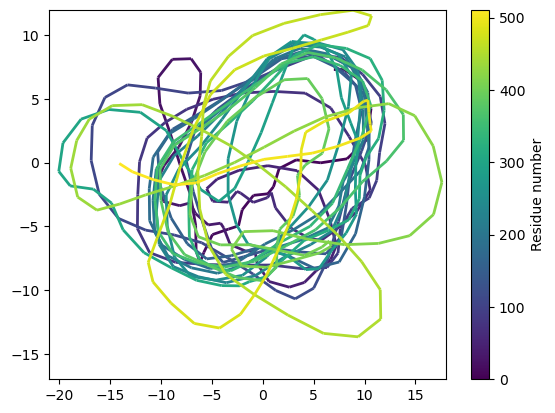

In [ ]:
#plot for projection onto normal bundle
# x = Q[:, 0]
# y = Q[:, 1]
# points = np.array([x, y]).T.reshape(-1, 1, 2)
# segments = np.concatenate([points[:-1], points[1:]], axis=1)

# conf = range(len(dZ))
# fig, axs = plt.subplots(1, 1, sharex=True, sharey=True)
# norm = plt.Normalize(min(conf), max(conf))
# lc = LineCollection(segments, cmap='viridis', norm=norm)
# # Set the values used for colormapping
# lc.set_array(conf)
# lc.set_linewidth(2)
# line = axs.add_collection(lc)
# fig.colorbar(line, ax=axs, label = 'Residue number')

# plt.xlim(-21, 18)
# plt.ylim(-17, 12)

In [ ]:
# #multiple breakpoints
# def linear_func(x, m, b):
#     return m * x + b
# for tairid, uniid in unique_matches_d.items():
#     Q = np.load(make_path('npy', 'normal_bundle_projection', f"{tairid}.npy"))
#     s = Q[:,0]
#     c = Q[:,1]
#     ds = gaussian_filter(s, 0.5, order = 1)
#     dc = gaussian_filter(c, 0.5, order = 1)

#     r2 = s ** 2 + c ** 2

#     summand = (c * ds - s * dc) / r2

#     plt.plot(gaussian_filter(summand, 10.0))
#     plt.show()

#     g =np.cumsum(summand)
#     N = len(g)

#     A_l = []
#     param_l = []

#     maxBp = 2
#     from itertools import combinations
#     from collections import defaultdict
#     for numBp in range(1, maxBp+1):
#         A = []
#         param_d = defaultdict(lambda : [])
#         if numBp ==1:
#             breakpts = [ti for ti in range(2,N-2)]
#         else:
#             breakpts = [ti for ti in combinations(range(2,N-2), numBp) if np.min(np.diff(list(ti)))>5]
#         for ti in breakpts:
#             if type(ti) is int:                
#                 ti0 = [0]+[ti]+[N]
#             else:
#                 ti0 = [0]+list(ti)+[N]
#             loss = 0
#             for inf, sup in zip(ti0[:-1], ti0[1:]):
#                 (m_opt, b_opt), covariance = curve_fit(linear_func, range(inf, sup), g[inf:sup])            
#                 coilRes = (g[inf:sup] - [linear_func(x, m_opt, b_opt) for x in range(inf, sup)])
#                 loss += np.sum(coilRes**2)
#             A.append(loss)
#             param_d[ti].append((m_opt, b_opt))
#         minidx = np.argmin(A)
#         minti = breakpts[minidx]
#         min_param = param_d[minti]
#         param_l.append(min_param)
#         A_l.append(A[minidx])
#     print(A_l)

In [ ]:
A = []
param_l = []
for t in range(2, N):

    params, covariance = curve_fit(linear_func, range(t), g[:t])
    m_opt, b_opt = params

    coilRes = (g[:t] - [linear_func(x, m_opt, b_opt) for x in range(t)])
    postCoilRes = (g[t:] - np.sum(g[t:]) / np.max([1, N-t]))/2

    A.append(np.sum(coilRes**2) + np.sum(postCoilRes**2))
    param_l.append((m_opt, b_opt))


/Users/boyanxu/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


In [ ]:
numPeriods = len([(ii,d) for ii, d in enumerate(np.diff(np.arctan2(s, c), n=1)) if d<-np.pi])
print(len(s)/numPeriods)

25.6


In [ ]:
for tairid in uniprot_d.keys():
    period = avgper(motifs_shifted_d[tairid])

    X = get_LRR_curve(tairid)
    X = X[:cutoff_d[tairid]]
    X = get_curv_vectors(X, MaxOrder=1, sigma=1)[1]
    # np.save(make_path('npy', 'nlrome_X', '%s.npy'%tairid), X)
            
    #print out the number of residues in the chain, and print the locations of the LRR motif residues

    D = get_csm(X, X)
    # Clean up the matrix a bit by doing a sliding window of length roughly the period
    D = sliding_window(D, period)
    # Clean up the matrix even more by binarizing it with nearest neighbors
    B = csm_to_binary_mutual(D, 50)
    #B = B[0:400, 0:400]
    v = getUnweightedLaplacianEigsDense(1-B)

    if True:
        plt.figure(figsize=(18, 6))
        plt.subplot(131)
        plt.imshow(D, cmap='magma_r')
        plt.title("Self-Similarity Matrix")
        plt.subplot(132)
        plt.imshow(B)
        plt.title("Binarized Self-Similarity Matrix")
        plt.subplot(133)
        plt.imshow(v[:, 0:29], aspect='auto', cmap='magma_r', interpolation='none')
        for ii in motifs_shifted_d[tairid]:
            if ii in range(v.shape[0]):
                plt.axhline(ii)
        plt.title("Eigenvectors of Unweighted Graph Laplacian")
        plt.savefig(make_path('plots','eigenmatrix_nlrome_cutoff', '%s.png'%tairid))
        plt.close()

    np.save(make_path('npy', 'eigenmatrix_nlrome_cutoff', '%s.npy'%tairid), v)
    

[[0, 103]]


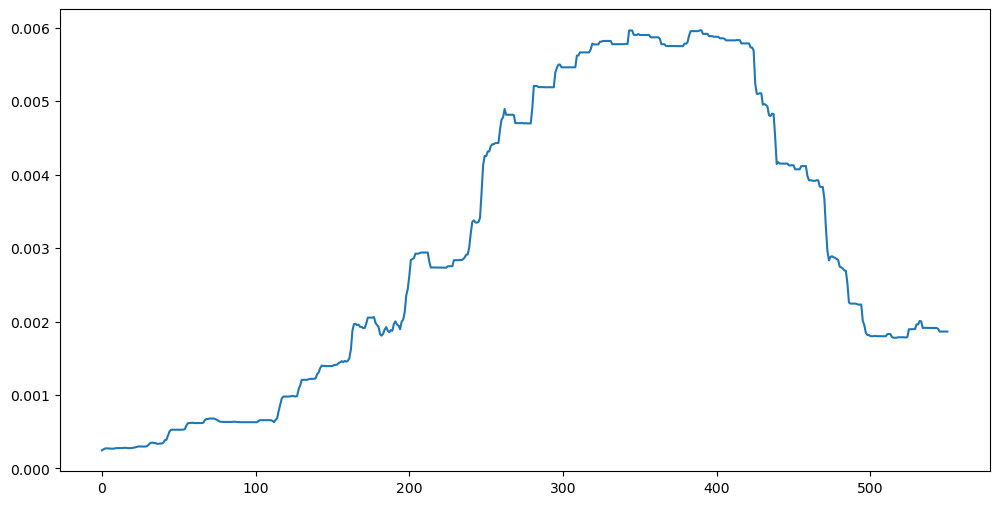

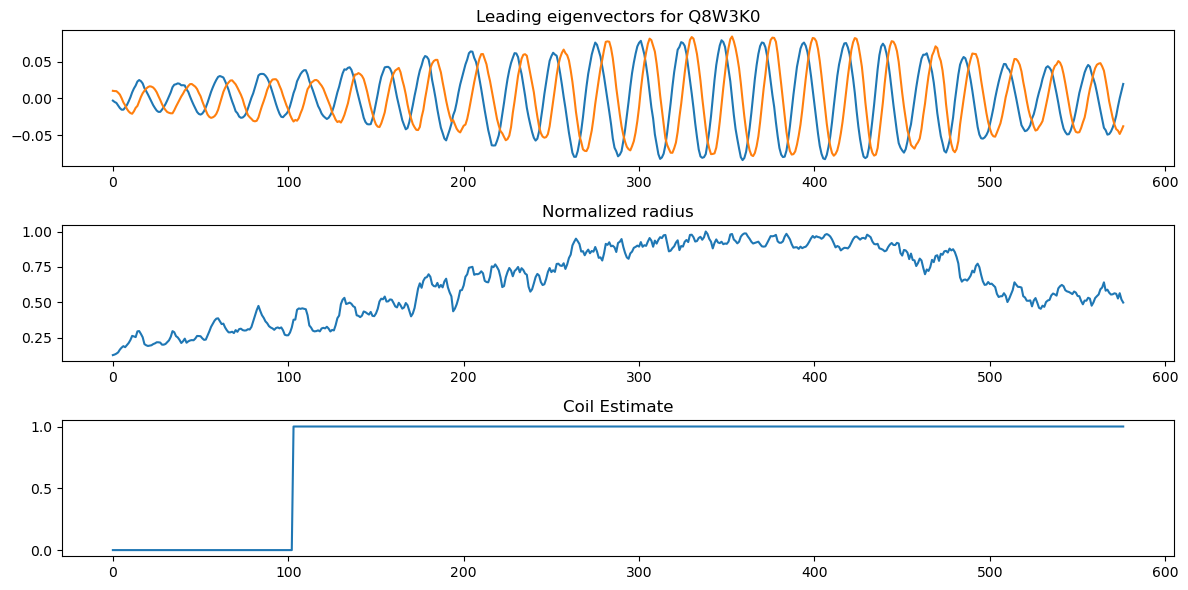

In [ ]:
#generate eigenvector plots
for tairid,uniid in unique_matches_d.items():
    motifs_l = motifs_shifted_d[tairid]
    period = avgper(motifs_shifted_d[tairid])

    if tairid != 'AT1G58602.1':
        continue
    for eig1, eig2 in [(0,1)]:
        v = np.load('npy/eigenmatrix_nlrome/%s.npy'%tairid)

        # plt.figure(figsize=(12, 4))
        s = v[:,eig1]
        c = v[:,eig2]

        # plt.show()
        # Detrend with daps
        sf = detrend_timeseries(s, period)
        cf = detrend_timeseries(c, period)

    # print(.shape)

    r = np.sqrt(s**2+c**2)
    r = r/np.max(r)
    coil_est = estimate_coil_hmm(s, c)
    print(get_hairpins(coil_est))

    X=v[:, eig1:eig2+1]
    windowSize = 25
    totpers_l=[]
    for windowStart in range(X.shape[0]- windowSize-1):
        Y = X[windowStart:windowStart+windowSize,:]
        stree = gd.AlphaComplex(points = Y).create_simplex_tree()
        dgm = stree.persistence()
        dgm1_lens = [d-b for (dim, (b, d)) in dgm if dim == 1]
        dgmstat = sum(dgm1_lens)
        # gd.plot_persistence_diagram(dgm, legend = True)
        totpers_l.append(dgmstat)
    plt.figure(figsize=(12, 6))
    plt.plot(totpers_l)
    plt.show()
    plt.close()

    plt.figure(figsize=(12, 6))
    plt.subplot(311)
    plt.plot(s)
    plt.plot(c)
    plt.title("Leading eigenvectors for %s"%uniid)
    plt.subplot(312)
    plt.plot(r)
    plt.title("Normalized radius")
    plt.subplot(313)
    plt.plot(coil_est)
    plt.title("Coil Estimate")
    plt.tight_layout()    
    # plt.title(f"Eigenvectors 0 and 1 for {tairid}")
    plt.show()

    # plt.savefig(make_path('plots','hairpin_nlrome', '%s.png'%tairid))
    
    plt.close()

    theta = np.arctan2(cf, sf)
    plt.figure(figsize=(12, 4))
    plt.plot(theta, label=f'{eig1}, {eig2}')
    plt.close()


  

In [ ]:
#generate eigenvector plots
for tairid,uniid in unique_matches_d.items():
    motifs_l = motifs_shifted_d[tairid]
    period = 25

    # if tairid != 'AT1G63730.1':
    #     continue

    v = np.load('npy/eigenmatrix_nlrome/%s.npy'%tairid)

        # plt.figure(figsize=(12, 4))
    v1 = v[:,eig1]
    v2 = v[:,eig2]

    v1f = detrend_timeseries(v1, period)
    v2f = detrend_timeseries(v2, period)

    r = np.sqrt(v1**2+v2**2)
    r = r/np.max(r)

    coil_est = estimate_coil_hmm(v1, v2)
    print(get_hairpins(coil_est))    

    theta = np.arctan2(v1f, v2f)

    dv1 = gaussian_filter(v1, 0.5, order = 1)
    dv2 = gaussian_filter(v2, 0.5, order = 1)

    r2 = v1 ** 2 + v2 ** 2

    summand = (v1 * dv2 - v2 * dv1) / r2

    windowSize = period
    totpers_l=[]
    X=np.stack((v1, v2), axis = 1)
    for windowStart in range(X.shape[0]- windowSize-1):
        Y = X[windowStart:windowStart+windowSize,:]
        stree = gd.AlphaComplex(points = Y).create_simplex_tree()
        dgm = stree.persistence()
        dgm1_lens = [d-b for (dim, (b, d)) in dgm if dim == 1]
        dgmstat = sum(dgm1_lens)
        # gd.plot_persistence_diagram(dgm, legend = True)
        totpers_l.append(dgmstat)
      


    plt.figure(figsize=(12, 8))
    plt.subplot(511)
    plt.plot(v1)
    plt.plot(v2)
    plt.title("Original")
    plt.subplot(512)
    plt.plot(r)
    plt.ylim([0, 1.1])
    plt.title("Original radius")
    plt.subplot(513)
    plt.plot(coil_est)
    plt.title("Coil Estimate")
    plt.subplot(514)
    plt.plot(summand)
    plt.title('Derivative of angular coordinate')
    plt.subplot(515)
    plt.plot(totpers_l)
    plt.title('SWTP')
    plt.tight_layout()    
    # plt.show()

    plt.savefig(make_path('plots','coil_swtp_summand_nlrome', '%s.png'%tairid))
    plt.close()

    continue

        # plt.show()
        # Detrend with daps
    sf = detrend_timeseries(s, period)
    cf = detrend_timeseries(c, period)

    # print(.shape)

    v1filt, v2filt = demodulate(s, c)
    r = np.sqrt(s**2+c**2)
    r = r/np.max(r)
    rfilt = np.sqrt(v1filt**2+v2filt**2)
    rfilt = rfilt/np.max(rfilt)

    coil_est = estimate_coil_hmm(v1filt, v2filt)
    print(get_hairpins(coil_est))   



    plt.figure(figsize=(12, 8))
    plt.subplot(611)
    plt.plot(s)
    plt.plot(c)
    plt.title("Original")
    plt.subplot(612)
    plt.plot(r)
    plt.ylim([0, 1.1])
    plt.title("Original radius")
    plt.subplot(613)
    plt.plot(totpers_l)
    plt.ylim([0, 1.1])
    plt.title("SWTP")
    plt.subplot(614)
    plt.plot(v1filt)
    plt.plot(v2filt)
    plt.title("Demodulated")
    plt.subplot(615)
    plt.plot(rfilt)
    plt.ylim([0, 1.1])
    plt.title("Demodulated radius")
    plt.subplot(616)
    plt.plot(coil_est)
    plt.title("Coil Estimate")
    plt.tight_layout()    
    plt.savefig(make_path('plots','hairpin_nlrome_demod', '%s.png'%tairid))
    plt.close()

    if False:
        X=v[:, eig1:eig2+1]
        windowSize = 25
        totpers_l=[]
        for windowStart in range(X.shape[0]- windowSize-1):
            Y = X[windowStart:windowStart+windowSize,:]
            stree = gd.AlphaComplex(points = Y).create_simplex_tree()
            dgm = stree.persistence()
            dgm1_lens = [d-b for (dim, (b, d)) in dgm if dim == 1]
            dgmstat = sum(dgm1_lens)
            # gd.plot_persistence_diagram(dgm, legend = True)
            totpers_l.append(dgmstat)
        plt.figure(figsize=(12, 6))
        plt.plot(totpers_l)
        plt.show()
        plt.close()

    
    if False:
        theta = np.arctan2(cf, sf)
        plt.figure(figsize=(12, 4))
        plt.plot(theta, label=f'{eig1}, {eig2}')
        plt.show()
        plt.close()





[[0, 18], [50, 62], [205, 250]]
[]
[[0, 19]]
[]
[[108, 124]]
[[0, 77]]
[[0, 10], [219, 273]]
[[0, 10], [137, 152]]
[[0, 13]]
[]
[[0, 68], [378, 418]]
[[0, 14], [47, 67], [333, 354]]
[[220, 250], [279, 296]]
[[0, 76], [325, 350]]
[[230, 239], [286, 294]]
[[0, 26], [68, 93], [318, 355]]
[]
[[0, 7]]
[[0, 15]]
[[0, 110], [209, 245], [474, 1073], [1117, 1138]]
[]
[[0, 24]]
[[0, 23], [206, 254]]
[[0, 102]]
[[276, 285]]
[[0, 51], [343, 369]]
[[40, 59], [241, 255]]
[[0, 48], [278, 308], [381, 438]]
[[44, 64]]
[]
[[0, 24]]
[[287, 294]]
[[223, 261], [283, 301]]
[[42, 68]]
[[0, 70], [91, 111], [378, 400]]
[[0, 51], [87, 104]]
[[0, 49], [91, 108]]
[[219, 240]]
[[217, 241], [285, 293]]
[[0, 19], [53, 77]]
[[0, 5]]
[[0, 20], [56, 82], [304, 335]]
[[0, 47], [82, 99], [362, 385]]
[[0, 87]]
[[0, 5]]
[[0, 70], [215, 229], [316, 330]]
[[0, 10], [255, 262], [399, 432]]
[[223, 257], [288, 303]]
[[0, 20]]
[[0, 5]]
[[0, 7], [249, 257], [394, 419]]
[[280, 287]]
[[0, 29]]
[[0, 26]]
[[0, 14]]
[]
[[219, 240]]
[[

In [ ]:
#generate eigenvector plots
for tairid in matches_d.keys():
    motifs_l = motifs_shifted_d[tairid]
    period = avgper(motifs_shifted_d[tairid])

    
    # if tairid!='AT4G27190.1':
        # continue
    for eig1, eig2 in [(0,1)]:
        v = np.load('npy/eigenmatrix_nlrome/%s.npy'%tairid)

        # plt.figure(figsize=(12, 4))
        s = v[:,eig1]
        c = v[:,eig2]

        # plt.show()
        # Detrend with daps
        sf = detrend_timeseries(s, period)
        cf = detrend_timeseries(c, period)

    # fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
    # ax1.plot(s, color='blue')
    # ax1.plot(c, color='orange')
    # ax2.plot(s**2+c**2, color='red')
    # plt.subplots_adjust(hspace=0.4)

    r = np.sqrt(s**2+c**2)
    r = r/np.max(r)
    coil_est = estimate_coil_hmm(s, c)
    print(get_hairpins(coil_est))

    plt.figure(figsize=(12, 6))
    plt.subplot(311)
    plt.plot(s)
    plt.plot(c)
    plt.title("Eigenvectors")
    plt.subplot(312)
    plt.plot(r)
    plt.title("Normalized radius")
    plt.subplot(313)
    plt.plot(coil_est)
    plt.title("Coil Estimate")
    plt.tight_layout()    
    # plt.title(f"Eigenvectors 0 and 1 for {tairid}")

    # plt.show()

    plt.savefig(make_path('plots','hairpin_nlrome', '%s.png'%tairid))
    
    plt.close()

[[0, 18], [50, 62], [205, 250]]
[]
[[0, 19]]
[]
[[108, 124]]
[[0, 77]]
[[0, 10], [219, 273]]
[[0, 10], [137, 152]]
[[0, 13]]
[]
[[0, 68], [378, 418]]
[[0, 14], [47, 67], [333, 354]]
[[220, 250], [279, 296]]
[[0, 76], [325, 350]]
[]
[[230, 239], [286, 294]]
[[0, 26], [68, 93], [318, 355]]
[]
[[0, 7]]
[[0, 15]]
[[0, 110], [209, 245], [474, 1073], [1117, 1138]]
[]
[[0, 24]]
[[0, 23], [206, 254]]
[[0, 102]]
[[276, 285]]
[[0, 51], [343, 369]]
[[40, 59], [241, 255]]
[[0, 48], [278, 308], [381, 438]]
[[44, 64]]
[]
[[0, 24]]
[[287, 294]]
[[0, 13]]
[[223, 261], [283, 301]]
[[42, 68]]
[[0, 70], [91, 111], [378, 400]]
[[0, 51], [87, 104]]
[[0, 49], [91, 108]]
[[219, 240]]
[[217, 241], [285, 293]]
[[0, 19], [53, 77]]
[[0, 5]]
[[0, 20], [56, 82], [304, 335]]
[[0, 47], [82, 99], [362, 385]]
[[0, 87]]
[[0, 5]]
[[0, 70], [215, 229], [316, 330]]
[[0, 10], [255, 262], [399, 432]]
[[0, 76], [325, 350]]
[[223, 257], [288, 303]]
[[0, 20]]
[[0, 5]]
[[0, 7], [249, 257], [394, 419]]
[[280, 287]]
[[0, 29]]
[[0

In [ ]:
#generate phase estimation plots
for tairid, uniid in unique_matches_d.items():
    motifs_l = motifs_shifted_d[tairid]
    period = avgper(motifs_shifted_d[tairid])
    
    plt.figure(figsize = (12,6))
    for eig1, eig2 in [(0,1)]:
        v = np.load('npy/eigenmatrix_nlrome/%s.npy'%tairid)

        plt.figure(figsize=(12, 4))
        s = v[:,eig1]
        c = v[:, eig2]
   
        plt.plot(s, label = '0')
        plt.plot(c, label = '1')
        plt.title('Leading eigenvector pair for protein %s'%uniid)
        plt.legend()
        plt.xlabel("Protein residue position")
        plt.savefig(make_path('plots','nlrome_eigplot', '%s.png'%tairid))

        plt.close()
        # Detrend with daps
        sf = detrend_timeseries(s, period)
        cf = detrend_timeseries(c, period)

        plt.figure(figsize=(12, 6))
        plt.subplot(121)
        plt.plot(sf)
        plt.plot(cf)
        plt.title("Detrended leading eigenvectors")
        plt.subplot(122)
        plt.title("Detrended Joint Plot for %s"%uniid)
        plt.xlabel('Eigenvector 0 value')
        plt.ylabel('Eigenvector 1 value')
        plt.plot(sf, cf)
        plt.savefig(make_path('plots','joint_plot_nlrome', '%s.png'%tairid))
        plt.close()

        # Extract the final phase and plot

        theta = np.arctan2(cf, sf)
        plt.figure(figsize=(12, 4))
        plt.plot(theta, label=f'{eig1}, {eig2}')

        # phases = []
        # for res in motifs_l:
        #     if res in range(len(theta)):
        #         plt.plot(res, theta[res], 'bo')
        #         phases.append(theta[res])

    plt.title(f"Estimated phase for {uniid}")
    plt.ylabel('Angle')
    plt.xlabel('Residue number')
    plt.savefig(f'plots/phase_estimation_nomotif/{tairid}.png')
        
    plt.close()


/var/folders/m0/rpw4gcbn5lxd8_3kt7g699rc0000gn/T/ipykernel_61063/3778648476.py:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(12, 4))
/var/folders/m0/rpw4gcbn5lxd8_3kt7g699rc0000gn/T/ipykernel_61063/3778648476.py:25: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(12, 6))
/var/folders/m0/rpw4gcbn5lxd8_3kt7g699rc0000gn/T/ipykernel_61063/3778648476.py:41: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until expli

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

In [ ]:
motifs_l

[54, 84, 106, 129, 152, 175, 196, 237, 261, 284, 305, 325, 347]

In [ ]:
cutoff_d[tairid]

370

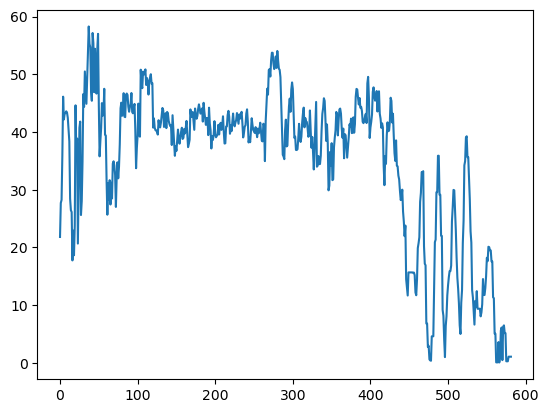

In [ ]:
plt.plot(x, y)

0 247


FileNotFoundError: [Errno 2] No such file or directory: 'swtp/AT5G45050.1.png'

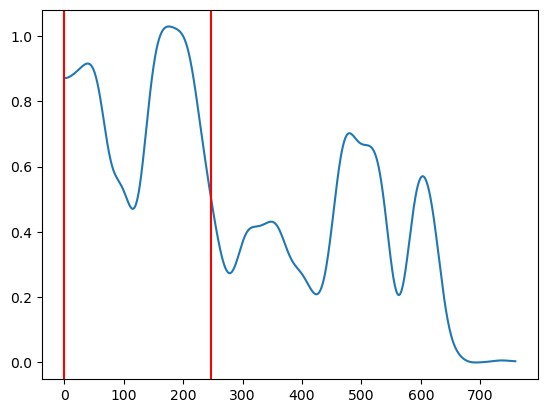

In [ ]:
g = gaussian_filter1d(swtp, 15)
g = g-np.min(g)

g = g/np.quantile(g, .95)
N= g.shape[0]

mins = []
argmins = []
for a in range(int(.2*N)):
    def f(x):
        return np.sum(np.array([g[ii] - 1 if a < ii < x else g[ii] for ii in range(N)])**2)
    res = minimize_scalar(f, bounds = (a, N), method='bounded')
    mins.append(res.fun)
    argmins.append(int(res.x))

a = np.argmin(mins)
b = argmins[a]
print(a,b)

plt.plot(g)
plt.axvline(a, color = 'r')
plt.axvline(b, color = 'r')
plt.savefig(make_path('plots','swtp', '%s.png'%tairid))
plt.close()

In [ ]:
argmins

[671,
 671,
 671,
 671,
 671,
 671,
 671,
 670,
 670,
 670,
 671,
 671,
 670,
 670,
 670,
 671,
 671,
 671,
 671,
 671,
 671,
 670,
 671,
 671,
 671,
 671,
 671,
 670,
 670,
 671,
 670,
 671,
 671,
 671,
 671,
 670,
 671,
 671,
 671,
 671,
 671,
 671,
 671,
 670,
 670,
 670,
 671,
 671,
 670,
 671,
 671,
 671,
 671,
 671,
 671,
 670,
 671,
 671,
 671,
 670,
 671,
 671,
 671,
 671,
 670,
 671,
 671,
 671,
 671,
 670,
 671,
 671,
 671,
 671,
 671,
 671,
 671,
 671,
 671,
 671,
 671,
 684,
 671,
 670,
 685,
 671,
 671,
 670,
 670,
 671,
 670,
 670,
 671,
 671,
 670,
 671,
 671,
 670,
 670,
 670,
 670,
 671,
 671,
 671,
 671,
 670,
 671,
 671,
 671,
 671,
 671,
 671,
 671,
 671,
 671,
 671,
 671,
 671,
 671,
 671,
 671,
 671,
 671,
 671,
 671,
 671,
 671,
 671,
 671,
 671,
 672,
 671,
 671,
 671,
 672,
 671,
 671,
 671,
 670,
 693,
 671,
 671,
 671,
 671,
 671,
 671,
 671,
 671,
 671,
 671,
 670,
 671,
 671,
 671,
 670,
 671,
 671]

0 671


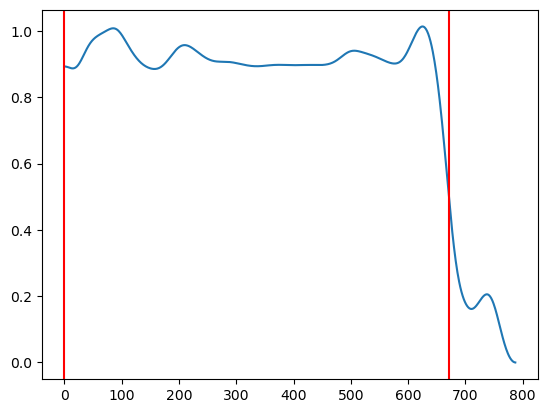

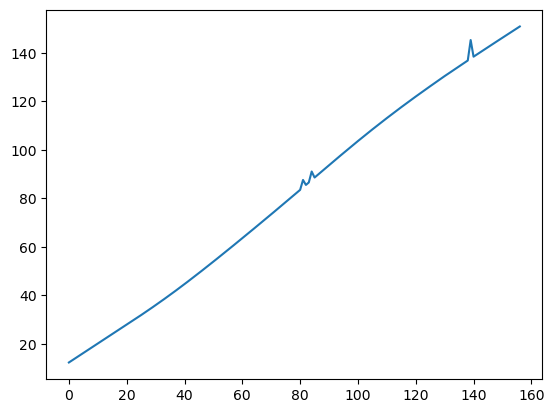

In [ ]:
plt.plot(mins)

[400.00000881]


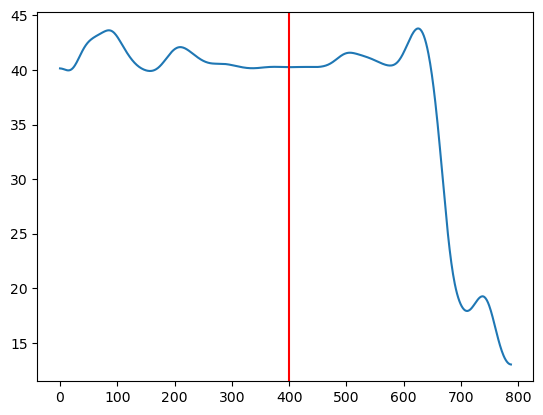

In [ ]:
from scipy.optimize import minimize

swtp = gaussian_filter1d(totpers_d['AT1G69550.1'], 15)

def f(x):
    return np.sum(np.array([swtp[ii] - 40 if ii<x[0] else swtp[ii] for ii in range(swtp.shape[0])])**2)

res_1 = minimize(f, [400], bounds = [(0, len(swtp))])

a = res_1.x[0]
print(res_1.x)
plt.plot(swtp)
plt.axvline(a, color = 'r')

In [ ]:
def f(x):
    return np.sum(np.array([swtp[ii] - 40 if ii<x else swtp[ii] for ii in range(swtp.shape[0])])**2)

res = minimize_scalar(f, bounds = (0, len(swtp)), method='bounded')

     fun: 48098.04667267787
 message: 'Solution found.'
    nfev: 28
     nit: 28
  status: 0
 success: True
       x: 675.5420087357162

In [ ]:
f(400)

TypeError: unsupported operand type(s) for ** or pow(): 'list' and 'int'

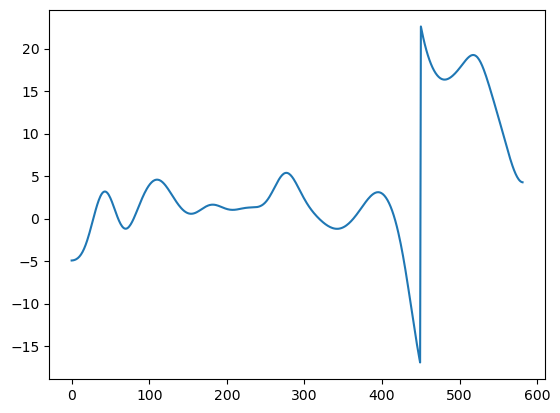

In [ ]:
plt.plot(f([450]))

array([150.00000908,  40.95152643])

In [ ]:
f([0, 450, 40])

[-4.925948949596467,
 -4.919270893073801,
 -4.90556810527589,
 -4.884575160531554,
 -4.855585046199721,
 -4.81797237659022,
 -4.770831506008982,
 -4.713187927518959,
 -4.64393230318916,
 -4.561991051209205,
 -4.466330626705606,
 -4.35587104015503,
 -4.229498366356154,
 -4.086183818455289,
 -3.9252591356731017,
 -3.746158609631941,
 -3.5483905946213383,
 -3.33193123979526,
 -3.096839849238876,
 -2.8435010231064837,
 -2.572811814979133,
 -2.2858641986536483,
 -1.9839840073170194,
 -1.6689713764529728,
 -1.342779395441596,
 -1.0077150108667325,
 -0.6663988881211509,
 -0.3217087970281014,
 0.02333514134971182,
 0.36564368566891403,
 0.7019012464210874,
 1.0288990953081694,
 1.343296353905572,
 1.6417753933719226,
 1.921108833454653,
 2.1785059991966875,
 2.4112934790433442,
 2.616965772071879,
 2.793147655563459,
 2.9383133380041784,
 3.0509828687300313,
 3.1304324330441915,
 3.1759010897321645,
 3.18727025108209,
 3.1650906595019066,
 3.109987028146058,
 3.0233049800198657,
 2.90674585703

In [ ]:
windowSize = 25

print(windowSize)
totpers_l=[]
for windowStart in range(X.shape[0]- windowSize-1):
    Y = X[windowStart:windowStart+windowSize,:]
    stree = gd.AlphaComplex(points = Y).create_simplex_tree()
    dgm = stree.persistence()
    dgm1_lens = [d-b for (dim, (b, d)) in dgm if dim == 1]
    dgmstat = sum(dgm1_lens)
    # gd.plot_persistence_diagram(dgm, legend = True)
    totpers_l.append(dgmstat)
    print(windowStart, dgmstat)


    # break

25
0 21.80826486451479
1 27.699855001932498
2 28.226313006093704
3 35.89810109518932
4 46.120190680879375
5 42.16835854107928
6 43.21129829061274
7 43.27977569807347
8 43.58245086584389
9 43.37820381861611
10 42.46569412201304
11 40.33818338551249
12 38.37531240929629
13 28.441762071575777
14 26.442654440289843
15 26.12483595570041
16 17.743820772739586
17 22.913805595233224
18 18.639813950194625
19 23.824066852183734
20 44.620252556202736
21 35.95059485210354
22 38.873754155186056
23 20.663892864977637
24 31.225739367587863
25 40.72621140101489
26 41.800981173588895
27 25.60767476046262
28 28.04497833185551
29 34.873337505550026
30 46.574334229463716
31 44.36231854052792
32 50.4916719696099
33 47.75037062994221
34 44.88434565504913
35 49.16729008381289
36 53.41032889035283
37 58.286798759241975
38 55.24742391976227
39 54.70932491082473
40 47.105121710648305
41 45.412442256537105
42 57.15801802692992
43 55.36289285411404
44 46.896930892808825
45 54.427082236508255
46 50.94499419095585


In [ ]:
np.save('npy/totpers_%s.npy'%tairid, totpers_l)

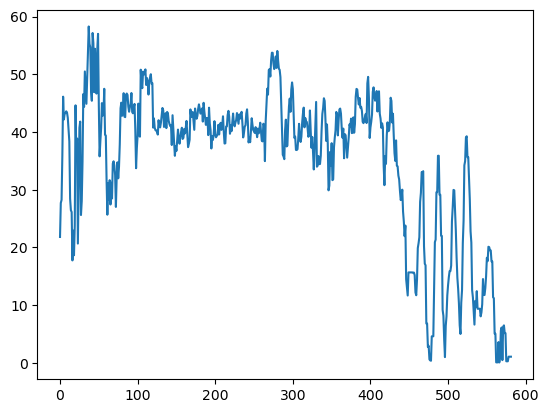

In [ ]:
plt.plot(totpers_l)

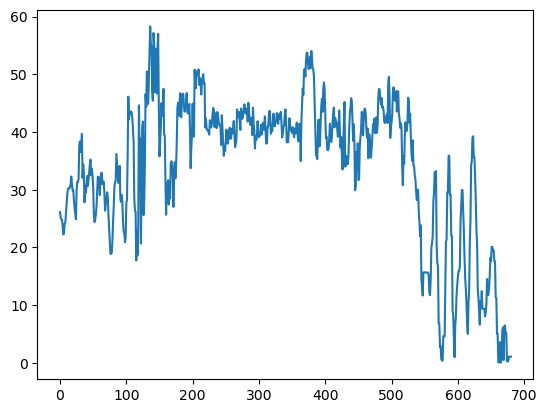

In [ ]:
plt.plot(totpers_l)